# AMAZON SALES DATASET

Amazon was founded by Jeff Bezos in 1994  that originally began as an online bookstore and quickly expanded to become one of the world's largest e-commerce marketplaces that sells virtually everything from books to electronics to groceries and clothing. In the modern day, Amazon's portfolio includes retail, cloud computing, digital streaming, and artificial intelligence. As Amazon become larger every single year, the challange to keep the company growth will be a massive challange. The purpose of this analysis is to tackle 3 key components in Amazon that is Shipping Efficiency, Customer Retention and Loyalty, and Predictive Analytics. The dataset was collected from kaggle website:
https://www.kaggle.com/datasets/anandshaw2001/amazon-sales-dataset/data



In [54]:
import pandas as pd
import numpy as np

# Import the 'seaborn' and 'matplotlib.pyplot' libraries for data visualization.
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Load data
df = pd.read_csv('Amazon_Raw.csv')

### Exploratory Data Analysis (EDA)
Performing EDA is a critical initial step in the data analysis process that involves examining and summarizing the main characteristics of a data set before applying more formal statistical or machine learning models.

In [10]:
# Check for the first six row of the dataset
df.head()

,Order ID,Order Date,Ship Date,EmailID,Geography,Category,Product Name,Sales,Quantity,Profit
0,CA-2013-138688,13/6/2013,17/6/2013,DarrinVanHuff@gmail.com,"United States,Los Angeles,California",Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2.0,6.87
1,CA-2011-115812,9/6/2011,14/6/2011,BrosinaHoffman@gmail.com,"United States,Los Angeles,California",Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7.0,14.17
2,CA-2011-115812,9/6/2011,14/6/2011,BrosinaHoffman@gmail.com,"United States,Los Angeles,California",Art,Newell 322,7.28,4.0,1.97
3,CA-2011-115812,9/6/2011,14/6/2011,BrosinaHoffman@gmail.com,"United States,Los Angeles,California",Phones,Mitel 5320 IP Phone VoIP phone,907.15,4.0,90.72
4,CA-2011-115812,9/6/2011,14/6/2011,BrosinaHoffman@gmail.com,"United States,Los Angeles,California",Binders,DXL Angle-View Binders with Locking Rings by S...,18.50,3.0,5.78


In [11]:
# Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      3203 non-null   object 
 1   Order Date    3203 non-null   object 
 2   Ship Date     3203 non-null   object 
 3   EmailID       3203 non-null   object 
 4   Geography     3203 non-null   object 
 5   Category      3203 non-null   object 
 6   Product Name  3203 non-null   object 
 7   Sales         3203 non-null   float64
 8   Quantity      3203 non-null   float64
 9   Profit        3203 non-null   float64
dtypes: float64(3), object(7)
memory usage: 250.4+ KB


In [12]:
# missing values
df.isna().sum()

Order ID        0
Order Date      0
Ship Date       0
EmailID         0
Geography       0
Category        0
Product Name    0
Sales           0
Quantity        0
Profit          0
dtype: int64

In [13]:
# duplicated values
# To check if there is any duplication in the dataset
df.duplicated().sum()

0

In [14]:
# Describe data
df.describe()

,Sales,Quantity,Profit
count,3203.000000,3203.000000,3203.000000
mean,226.493266,3.828910,33.849138
std,524.876911,2.260947,174.109155
min,0.990000,1.000000,-3399.980000
25%,19.440000,2.000000,3.850000
50%,60.840000,3.000000,11.170000
75%,215.810000,5.000000,33.000000
max,13999.960000,14.000000,6719.980000


In [21]:
# make a copy of the current data frame
amazon = df.copy()

### Customer Segmentation

Customer segmentation is a marketing strategy that involves dividing a customer base into smaller groups of individuals that share similar characteristics. The goal of customer segmentation is to allow companies to tailor marketing strategies and product offerings to meet the specific needs for customers leading to more efficient use of marketing resources and higher customer satisfaction and loyalty. There are several benefits of customer segmentation such as improved customer retention, efficient resource management and product recommendations. 

For this analysis, RFM analysis technique are selected as it categorizes customers based on their transaction history. The RFM stands for Recency, Frequency, and Monetary value, each corresponding to key customer traits. This technique is usefull for identifying which customers are most likely to respond to new offers and which ones are most profitable or loyal.

In [17]:
#  import the datetime module 
import datetime as dt

In [28]:
# Convert Order Dates to Monthly Periods
# Comparing data on a month-by-month basis rather than on specific dates
amazon['order_month'] = amazon['Order Date'].dt.to_period('M')

# Determine the Cohort Month for Each Customer
# Assigns every transaction of a customer to the cohort of their first purchase month
amazon['cohort_month'] = amazon.groupby('EmailID')['order_month'].transform('min')

# Calculate the Cohort Index
# Represents how many months have passed since the first purchase within that customer's cohort
amazon['cohort_index'] =  abs(amazon['order_month'].dt.month - amazon['cohort_month'].dt.month) + 1

In [29]:
# Creating reference date
reference_date = amazon['Order Date'].max()  + dt.timedelta(days=1)

In [31]:
# Calculate RFM metrics
rfm_metrics = amazon.groupby(['EmailID']).agg({
    'Order Date': lambda x: (reference_date - x.max()).days,  # Recency: Days since last order
    'Order ID': 'count',                                      # Frequency: Total number of transactions
    'Sales': 'sum'                                            # Monetary: Total money spent
})

In [44]:
# Building RFM 
# Define quartiles 
recency_quartiles = pd.qcut(rfm_metrics['Order Date'], 4, labels=range(4,0,-1))
frequency_quartiles = pd.qcut(rfm_metrics['Order ID'], 4, labels=range(1,5))
monetary_quartiles = pd.qcut(rfm_metrics['Sales'], 4, labels=range(1,5))
rfm_metrics = rfm_metrics.assign(R=recency_quartiles,F=frequency_quartiles,M=monetary_quartiles)


In [46]:
# Creating RFM Segmentation
# Combining the Recency, Frequency, and Monetary scores into a unified segment
rfm_metrics['RFM_Segment'] = rfm_metrics['R'].astype(int).astype(str) + rfm_metrics['F'].astype(int).astype(str) + rfm_metrics['M'].astype(int).astype(str)

print(rfm_metrics[['R', 'F', 'M']].dtypes)


R    category
F    category
M    category
dtype: object


In [47]:
# Creating Score
rfm_metrics['RFM_Score'] = rfm_metrics[['R','F','M']].sum(axis=1)

In [51]:
# Count the number of customers in each segment
segment_distribution = rfm_metrics['RFM_Segment'].value_counts()
print(segment_distribution)


RFM_Segment
111    64
112    32
444    31
344    29
244    28
211    24
443    23
311    20
322    18
432    17
223    16
333    16
243    16
411    15
221    14
222    14
323    14
343    14
334    13
113    13
423    13
144    13
332    12
212    12
122    12
422    12
421    11
434    11
123    11
312    11
234    10
232     9
412     9
233     9
321     8
433     8
324     7
424     7
442     7
121     7
224     5
133     5
134     5
413     4
213     4
124     4
242     4
231     3
114     3
214     3
143     3
313     2
431     2
331     2
314     2
342     2
441     1
414     1
341     1
Name: count, dtype: int64


In [52]:
# Sorting to view the top 15
top_segments = segment_distribution.sort_values(ascending=False)
print(top_segments.head(15))


RFM_Segment
111    64
112    32
444    31
344    29
244    28
211    24
443    23
311    20
322    18
432    17
223    16
333    16
243    16
411    15
222    14
Name: count, dtype: int64


In [59]:
# Calculate average values for each RFM score within segments
segment_profiles = rfm_metrics.groupby('RFM_Segment').agg({
    'Order Date': 'mean',
    'Order ID': 'mean',
    'Sales': 'mean',
    'RFM_Score': 'mean' 
}).sort_values(by='RFM_Score', ascending=False)

print(segment_profiles)


              Order Date   Order ID        Sales  RFM_Score
RFM_Segment                                                
444            39.322581   9.741935  3095.614194       12.0
443            39.869565   9.260870   988.146522       11.0
434            44.727273   5.454545  2503.790909       11.0
344           137.724138  10.448276  2956.510000       11.0
442            22.000000   7.857143   513.525714       10.0
433            43.625000   5.500000  1167.742500       10.0
334           174.230769   5.538462  2709.221538       10.0
244           392.714286   9.392857  2929.039643       10.0
424            46.571429   3.714286  2518.872857       10.0
343           162.142857   9.785714  1026.774286       10.0
414            45.000000   1.000000  1919.980000        9.0
333           146.187500   5.812500  1085.463750        9.0
342           190.000000   7.000000   466.545000        9.0
243           358.500000   8.750000   977.748750        9.0
234           348.700000   5.600000  381

In [62]:
# Define the aggregation dictionary
aggregations = {
    'Order Date': 'mean',
    'Order ID': 'mean',
    'Sales': ['mean', 'count']
}

# Perform the groupby and aggregation
result = rfm_metrics.groupby('RFM_Score').agg(aggregations).round(1)

print(result)

          Order Date Order ID   Sales      
                mean     mean    mean count
RFM_Score                                  
3              957.1      1.3    69.0    64
4              712.5      1.7   217.8    63
5              542.5      2.2   362.8    71
6              371.0      2.7   473.5    69
7              278.5      3.5   642.7    79
8              271.6      4.6   942.1    73
9              265.2      6.1  1408.3    96
10             212.5      7.8  2106.2    77
11              85.8      9.1  2158.9    63
12              39.3      9.7  3095.6    31


In [64]:
# Create conditions for all segments
conditions = [
    rfm_metrics['RFM_Score'] > 9,
    (rfm_metrics['RFM_Score'] > 5) & (rfm_metrics['RFM_Score'] <= 9),
    rfm_metrics['RFM_Score'] <= 5
]

# Labels for each condition
labels = ['Gold', 'Silver', 'Bronze']

# Create new column called General Segment
rfm_metrics['General_Segment'] = np.select(conditions, labels, default='Bronze')

In [74]:
# Counts each segment and aligned the color code with segments
segment_counts = rfm_metrics['General_Segment'].value_counts().sort_index()

Text(0, 0.5, 'Number of Customers')

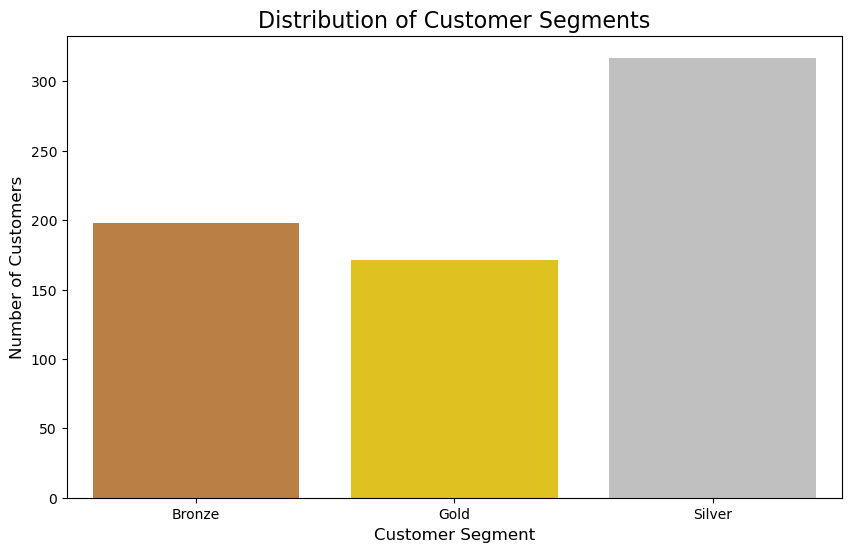

In [78]:
# create a bar plot
colors = ['#CD7F32','#FFD700','#C0C0C0']
plt.figure(figsize=(10, 6)) 
ax = sns.barplot(x=segment_counts.index, y=segment_counts.values, palette=colors)

plt.title('Distribution of Customer Segments', fontsize=16)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

### Based on this RFM analysis:
1. The silver segment are the largest compare to the others followed by bronze and gold. This shows that a lot of the customers showing moderate engaged segment, with moderate purchases, moderate time of inactivity, and moderate monetary value. This can be a good sign as customer quite frequently spending in the website but not frequent enough. Amazon will need to plan an event such as targeted marketing strategies, loyalty programs that can push this segment to gold segments. 
2. The bronze section could provide insights into what improvements could be made to the product line or customer service experience to increase their RFM scores.
3. Gold segments indicates customers who shop more recently, more frequently, and have spent more money. This is the customers that Amazon should look to retain for their lifetime as it yield the highest profit for the company. 